# VQE on the Hubbard molecule

We would like to study the "Hubbard dimer" molecule, whose Hamiltonian reads:

$$H=-t\sum_{\sigma=\uparrow,\downarrow}\left(c_{1\sigma}^{\dagger}c_{2\sigma}+c_{2\sigma}^{\dagger}c_{1\sigma}\right)-\mu\sum_{i=1,2}\sum_{\sigma=\uparrow,\downarrow}n_{i\sigma}+U\sum_{i=1,2}n_{i\uparrow}n_{i\downarrow}$$

with $n_{i\sigma} = c^\dagger_{i\sigma} c_{i\sigma}$. We will choose $\mu=U/2$ to keep the number of electrons at one per site.

In [1]:
import numpy as np
import random
import scipy.optimize

from qat.lang.AQASM import H, RX, RY, CNOT, QRoutine, Program
from qat.qpus import LinAlg
from qat.fermion.hamiltonians import make_hubbard_model
from qat.fermion.transforms import transform_to_jw_basis
from qat.plugins import SPSAMinimizePlugin

qpu = LinAlg()

distances = np.linspace(0.1, 2, 5)
exact_energies = []
vqe_energies = []
for r in distances:
    print("#### r = %s ####" % r)

    U = 1 / r  # supposing U depends on r this way...
    t = np.exp(-r)  # ditto
    nqbit = 4
    t_mat = -t * np.array([[0.0, 1.0], [1.0, 0.0]])
    hamilt = make_hubbard_model(t_mat, U, mu=U / 2)
    hamilt_sp = transform_to_jw_basis(hamilt)

    # eigvals, eigvecs = np.linalg.eig(hamilt.get_matrix())
    eigvals, eigvecs = np.linalg.eigh(hamilt_sp.get_matrix())
    E0 = min(eigvals)
    exact_energies.append(E0)
    print("exact energy = ", E0)

    prog = Program()
    reg = prog.qalloc(nqbit)
    theta = [prog.new_var(float, "\\theta_%s" % i) for i in range(8)]
    for layer in range(2):
        for qb in [0, 1, 2, 3]:
            prog.apply(H, reg[qb])
        for qb in [0, 1, 2, 3]:
            prog.apply(RY(theta[4 * layer + qb]), reg[qb])
            prog.apply(CNOT, reg[qb], reg[(qb + 1) % 4])

    circ = prog.to_circ()
    theta0 = 2.0 * np.pi * np.random.random(8)
    spsa_optimizer = SPSAMinimizePlugin(x0=theta0)
    stack = spsa_optimizer | qpu

    res = stack.submit(circ.to_job(job_type="OBS", observable=hamilt_sp))
    E0 = res.value
    vqe_energies.append(E0)
    print("VQE energy = ", E0)

#### r = 0.1 ####
exact energy =  -10.317416949263233
VQE energy =  -10.03648805728941
#### r = 0.575 ####
exact energy =  -2.2917785434479123
VQE energy =  -1.9065549534670088
#### r = 1.05 ####
exact energy =  -1.3227027812554648
VQE energy =  -1.0567286031401628
#### r = 1.525 ####
exact energy =  -0.8727850680163773
VQE energy =  -0.5976701423142394
#### r = 2.0 ####
exact energy =  -0.6184597068268616
VQE energy =  -0.38633632241133625


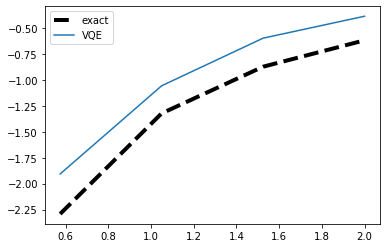

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.plot(distances[1:], exact_energies[1:], "--k", lw=4, label="exact")
plt.plot(distances[1:], vqe_energies[1:], label="VQE")
plt.legend()